In [1]:
from pyts.datasets import load_gunpoint
import matplotlib.pyplot as plt
import numpy as np
import mass_ts as mts

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

/Users/stefan-temp/Desktop/General/Privat/greedy-shapelet-search/venv-hyp-mar/lib/python3.9/site-packages/mass_ts/_mass_ts.py:17: UserWarning: GPU support will not work. You must pip install mass-ts[gpu].
  warnings.warn(


In [2]:
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

Goal:
Implement shapelet algorithm
Which set of shapelets is optimal

Ideas:
- mass algorithm for distance calculation
- greedy implementation (add next best fit until some criteria)
- divide and conquer
- bootstrapping 

1. sample 

In [3]:
y_train

array([2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 1, 2, 1, 2])

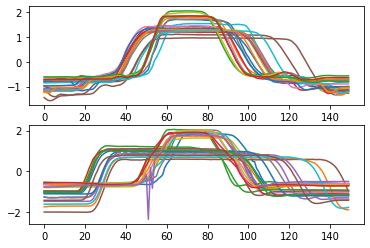

In [4]:
X_train.shape

fig, ax = plt.subplots(2)
ax[0].plot(X_train[y_train==1].T)
ax[1].plot(X_train[y_train==2].T)

In [5]:
X_train

array([[-0.6478854 , -0.64199155, -0.63818632, ..., -0.64042873,
        -0.63866571, -0.63865722],
       [-0.64442658, -0.64540093, -0.64705511, ..., -0.6349345 ,
        -0.6344968 , -0.63159565],
       [-0.77835282, -0.77827907, -0.77715084, ..., -0.70419626,
        -0.70760524, -0.7071202 ],
       ...,
       [-0.77912617, -0.77837863, -0.7757449 , ..., -0.50500603,
        -0.50373099, -0.50438486],
       [-0.70303339, -0.70261754, -0.70250356, ..., -0.64113375,
        -0.64140622, -0.64210896],
       [-1.4357199 , -1.4322717 , -1.4329285 , ..., -1.4354619 ,
        -1.4352821 , -1.4308845 ]])

In [3]:
def sampling(A,n):
    return A[np.random.randint(A.shape[0], size=n), :]
test = sampling(X_train,5)
test.shape

(5, 150)

In [4]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [8]:
x = X_train[:1]

windows = rolling_window(test,30)
print(windows.shape)

# distances = [mts.mass2(x.squeeze(), query) for query in windows.squeeze()]

# x.shape

(5, 121, 30)


1464100
CPU times: user 2.73 s, sys: 35.6 ms, total: 2.76 s
Wall time: 2.8 s


CPU times: user 105 ms, sys: 3.73 ms, total: 108 ms
Wall time: 107 ms


(1, 121, 30)

In [5]:
%%time


def get_candidate_mins(sample_data, shapelet_size = 10):
    """
    Function that calculates the distance of all candidates of a given data set to all all other candidates.
    CAREFUL:
    - memory blows up quickly.
    - contains the zeros (distance of candidates to itself)
    """
    windowed_data = rolling_window(sample_data, shapelet_size)
    return np.array([abs(windowed_data - series).sum(axis=-1) for series in windowed_data])

profiles = get_candidate_mins(X_train)

profiles.shape


CPU times: user 21.5 ms, sys: 4.52 ms, total: 26.1 ms
Wall time: 24.4 ms


(50, 50, 141)

In [10]:

%%time


from sklearn import svm
from sklearn.metrics import f1_score

def fit_svm(X,Y):
    """
    Fitting a SVM and returning the f1 score and the calculated margin.
    """
    clf = svm.SVC(kernel='linear')
    # Fit classifier
    clf.fit(X, Y)
    # Calculate margin
    margin = 1 / np.sqrt(np.sum(clf.coef_ ** 2))
    # Predict
    Y_pred = clf.predict(X)
    # Calculate f1 score
    f1 = f1_score(Y,Y_pred)
    return f1, margin

def get_scores_for_profiles(profiles, y_train, scoring_function):
    """
    Computes the scores for each candidate for each sample in a population of profiles.
    Requires labels.
    """
    list_samples = []
    # Iterating through all smaples in a population of profiles
    for sample in range(profiles.shape[0]):
        # For each candidate in a given sample, compute the boundary and f1 score (SVM)
        sample_scores = [scoring_function(np.expand_dims(profiles[sample,:,cand],axis=1), y_train) for cand in range(profiles.shape[2])]
        list_samples.append(sample_scores)
    return np.array(list_samples)

samples_scores = get_scores_for_profiles(profiles, y_train, fit_svm)


CPU times: user 7.22 s, sys: 24.5 ms, total: 7.24 s
Wall time: 7.26 s


In [22]:

def closest_neighbor(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).sum(axis=1).argmin()
    return array[idx], idx

def hypothesis_margin(x, X_target, X_other):
    return 1/2*(abs(x - closest_neighbor(X_other, x)) - abs(x - closest_neighbor(X_target, x)))

def cumulative_margin(X, y, target_class):
    X_target = X[y == target_class]
    X_other = X[y != target_class]
    return sum([hypothesis_margin(x, np.delete(X_target,idx), X_other) for idx, x in enumerate(X_target)])

    # for idx, row in X_target.iterrows()
    # for x in X[y == target_class]:    
    #     margin = 1/2*(abs(x - closest_neighbor(X[y!=target_class], x)) - abs(x - closest_neighbor(X[y==target_class], x)))
    #     cumulative_margin += margin
    # return cumulative_margin

print(1,X_train.shape)

test_s = X_train[0]

result_s, result_i = closest_neighbor(X_train,test_s)

print(result_i)

hypothesis_margin(X_train, y_train, target_class=1)



# start = time.time()
# a = hypothesis_margin(X, y, 1)
# print(time.time()-start)

1 (50, 150)
0
(24, 150)


In [13]:
def hm_decorator(X,y):
    return hypothesis_margin(X,y,target_class=1)

smaples_score_hm = get_scores_for_profiles(profiles,y_train,hm_decorator)

In [14]:
samples_scores[0].shape

(141, 2)

In [41]:
%%time
class GreedyShapeletSearch():
    """
    F: a function that finds the 'best' candidate
        F: scores each (additional) profile
            F: evaluates the margin (h-margin)
                F: h-margin
            F: 1-nn classifier
                    - 1 NN
                    - sorting: not needed because applying to minority class (majority class does not get computed)
        F: find next greedy optimal shapelet
        - Store shapelet
        - store shapelet distances (feature vector)
    """
    def __init__(self):
        self.shapelets = []

    def find_n_shapelets(self, profiles, y_profiles, target_class, n_shapelets):
        for _ in range(n_shapelets):
            self.score_profiles(profiles,y_profiles,target_class)
    
    def score_profiles(self, profiles, y_profiles, target_class):
        optimal_score = 0
        optimal_margin = 0
        optimal_shapelet = 0
        
        for sample_idx in range(profiles.shape[0]):
            sample = profiles[sample_idx]
            for candidate_idx in range(sample.shape[1]):
                # If a shapelet has already been found, add previous values to features
                if len(self.shapelets)>0:
                    extra_features = [profiles[shapelet[2][0],:,shapelet[2][1]] for shapelet in self.shapelets]
                    extra_features.append(sample[:,candidate_idx])
                    features= np.array(extra_features).T
                # Else only use candidate values
                else:
                    features = sample[:,candidate_idx]
                margin, score =self.score_candidate(features, y_profiles, target_class=target_class)
                
                if score > optimal_score:
                    optimal_margin = margin
                    optimal_score = score
                    optimal_shapelet = (sample_idx, candidate_idx)
                elif score == optimal_score:
                    if margin > optimal_margin:
                        optimal_margin = margin
                        optimal_score = score
                        optimal_shapelet = (sample_idx, candidate_idx)
        self.shapelets.append((optimal_score, optimal_margin,optimal_shapelet))
                
    @staticmethod
    def closest_neighbor(array, value):
        if len(array.shape)==1:
            array = np.expand_dims(array,axis=1)
        idx = (np.abs(array - value)).sum(axis=1).argmin()
        return array[idx]
 
    def hypothesis_margin(self, x, X_target, X_other):
        return 1/2*(np.linalg.norm(x - self.closest_neighbor(X_other, x)) - np.linalg.norm(x - self.closest_neighbor(X_target, x)))
    
    def score_candidate(self, X, y, target_class):
        X_target = X[y == target_class]
        X_other = X[y != target_class]
        margins = [self.hypothesis_margin(x, np.delete(X_target,idx), X_other) for idx, x in enumerate(X_target)]
        cumulative_margin = sum(margins)
        score = len([margin for margin in margins if margin < 0])/len(margins)
        return cumulative_margin, score
    

    # def recursive_top_shapelet(self, profiles, y_train, scoring_function, additional_features = None, number_shapelets = 1):

    #     # Recursive event loop that finds an 'optimal' shapelet at each iteration
    #     while self.num_shapelets < number_shapelets:
    #         samples_score = self.get_scores_for_profiles(profiles, y_train, scoring_function, additional_features)
    #         f1_scores = samples_scores[:,:,0]
            
    #         margin_filtering
    #         best_sample_id = np.unravel_index(f1_scores.argmax(), f1_scores.shape)



    #         best_sample_features = profiles[best_sample_id[0],:,best_sample_id[1]]
    #         self.best_shapelets.append(best_sample_id)
    #         self.best_shapelets_features.append(best_sample_features)

    #         if len(self.best_shapelets_features) > 1:
    #             additional_features = np.concatenate(self.best_shapelets_features, axis=1)
    #         else:
    #             additional_features = best_sample_features
    #         self.num_shapelets += 1
    #         self.recursive_top_shapelet(profiles, y_train, scoring_function, additional_features, number_shapelets)
        
    #     return

    # def margin_filtering(self):
    #     pass


    # def get_scores_for_profiles(self,profiles, y_train, scoring_function, additional_features=None ):
    #     """
    #     Computes the scores for each candidate for each sample in a population of profiles.
    #     Requires labels.
    #     """
    #     list_samples = []
    #     # Iterating through all smaples in a population of profiles
    #     for sample in range(profiles.shape[0]):
    #         # For each candidate in a given sample, compute the boundary and f1 score (SVM)
    #         def feature_decorator(column):
    #             if additional_features:
    #                 return np.concatenate([additional_features,column], axis=1)
    #             return column

    #         sample_scores = [scoring_function(feature_decorator(np.expand_dims(profiles[sample,:,cand],axis=1)), y_train) for cand in range(profiles.shape[2])]
    #         list_samples.append(sample_scores)
    #     return np.array(list_samples)

GSS = GreedyShapeletSearch()
# GSS.score_profiles(profiles, y_train)

GSS.find_n_shapelets(profiles, y_train, 1, n_shapelets=2)


CPU times: user 13.6 s, sys: 33 ms, total: 13.7 s
Wall time: 13.7 s


In [127]:
%%time

class GreedyShapeletSearch():
    def __init__(self):
        self.shapelets = []
        self.exclusion_zone = {}
        self.shapelet_size = 0

    @staticmethod
    def rolling_window(a, window):
        shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
        strides = a.strides + (a.strides[-1],)
        return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

    
    def get_candidate_mins(self, sample_data, shapelet_size = 10):
        """
        Function that calculates the distance of all candidates of a given data set to all all other candidates.
        CAREFUL:
        - memory blows up quickly.
        - contains the zeros (distance of candidates to itself)
        """
        windowed_data = self.rolling_window(sample_data, shapelet_size)
        # Standardize candidates
        windowed_data = self.standardize_samples_candidates(windowed_data)
        return np.array([abs(windowed_data - series).sum(axis=-1) for series in windowed_data])
    

    def main_event_loop(self, X_train, y_train, target_class = 1, n_shapelets=1, shapelet_size = 10):
        """
        The main event loop contains the series of steps required for the algorithm.
        """
        # Store shapelet size
        self.shapelet_size = shapelet_size
        # Calculate all of the candidate minimums throughout the dataset - shape: n_samples, n_samples, n_candidate
        profiles = self.get_candidate_mins(X_train, shapelet_size)
        # Extract a shapelet for n_shapelets
        for _ in range(n_shapelets):
            self.extract_optimal_shapelet(profiles, X_train, y_train, target_class)


    def add_shapelet_features(self, candidate, profiles):
        """
        Adds the features of previous optimal shapelets to the current candidate features.
        """
        # If no shapelet has been found yet, just use the candidate feature
        if len(self.shapelets) == 0:
            return candidate
        extra_features = [profiles[shapelet[2][0],:,shapelet[2][1]]for shapelet in self.shapelets]
        extra_features.append(candidate)
        return np.array(extra_features).T


    def extract_optimal_shapelet(self, profiles, X_train, y_train, target_class):
        """
        Extracts a (greedy) optimal shapelet.
        """

        optimal_score = 0
        optimal_margin = 0
        optimal_shapelet = 0

        # Iterate through all samples in profiles
        for sample_idx in range(profiles.shape[0]):
            # The minimum distances of the given samples candidates to all other samples - shape: n_samples, n_candidates
            sample = profiles[sample_idx]
            # Iterate through all candidate distances of the given sample
            for candidate_idx in range(sample.shape[1]):
                # Check if in exclusion zone
                if sample_idx in self.exclusion_zone.keys():
                    if candidate_idx in self.exclusion_zone[sample_idx]:
                        continue
                # The minimum distances of a candidate to all other samples
                candidate = sample[:,candidate_idx]
                candidate = self.add_shapelet_features(candidate, profiles)
                candidate = self.standardize_candidates(candidate)
                # Score candidate
                score, margin = self.score_candidate(candidate, y_train, target_class)

                if score > optimal_score:
                    optimal_margin = margin
                    optimal_score = score
                    optimal_shapelet = (sample_idx, candidate_idx)
                elif score == optimal_score:
                    if margin > optimal_margin:
                        optimal_margin = margin
                        optimal_score = score
                        optimal_shapelet = (sample_idx, candidate_idx)
        self.shapelets.append((optimal_score, optimal_margin,optimal_shapelet, X_train[optimal_shapelet[0],optimal_shapelet[1]:optimal_shapelet[1]+self.shapelet_size]))
        self.exclusion_zone[optimal_shapelet[0]] = list(range(optimal_shapelet[1]-self.shapelet_size,optimal_shapelet[1]+self.shapelet_size))

    def ISCH_DAT_IN_DER_LISTE(self, sample_idx, candidate_idx):
        pass
        

    def score_candidate(self, candidate, y_train, target_class):
        """
        This function evaluates a candidate based on the hypothesis margin.
        """
        # Split dataset into target class and other
        candidates_target = candidate[y_train == target_class]
        candidates_other = candidate[y_train != target_class]

        return self.cumulative_hypothesis_margin(candidates_target, candidates_other)

    def cumulative_hypothesis_margin(self,candidates_target, candidates_other):
        """
        Calculate the cumulative margin.
        """
        # Compute the hypothesis margins for all candidates_target
        margins = [self.hypothesis_margin(x, np.delete(candidates_target,idx), candidates_other) for idx, x in enumerate(candidates_target)]
        # Normalize the margins
        # margins = self.normalize_margins(margins)
        # Sum of all margins
        cumulative_margin = sum(margins)
        # All margins that are positive mean that the nearest neighbor is of the same class
        score = len([margin for margin in margins if margin > 0])/len(margins) 
        return score, cumulative_margin

    @staticmethod
    def normalize_margins(margins):
        return (margins-min(margins))/(max(margins)-min(margins))
    @staticmethod
    def standardize_candidates(candidates):
        # return (candidates-candidates.min(axis=0))/(candidates.max(axis=0)-candidates.min(axis=0))
        return (candidates-candidates.mean(axis=0))/candidates.std(axis=0)
    
    @staticmethod
    def standardize_samples_candidates(samples, axis=2):
        """
        Standardized each shapelet candidate (after windowing).
        """
        return (samples-np.expand_dims(samples.mean(axis=axis),axis))/np.expand_dims(samples.std(axis=axis),axis)

    def hypothesis_margin(self, x, candidates_target, candidates_other):
        """
        Calculate the hypothesis margin for a candidate.
        """
        margin_other = self.closest_neighbor(candidates_other, x)
        margin_target = self.closest_neighbor(candidates_target, x)
        margin = 1/2*(margin_other - margin_target)
        return margin

    def closest_neighbor(self, candidates, x):
        """
        Find the distance to the closest neighbor
        """
        if len(candidates.shape) == 1:
            candidates = np.expand_dims(candidates,axis=1)
        min_distance = (np.linalg.norm(candidates - x)).min()
        return min_distance

    def fit_classifier(self, X_train, y_train, X_test, y_test, classifier, scoring_function):
        features_train = self.features_transform(X_train)
        classifier.fit(X_train, y_train)
        features_test = self.features_transform(X_test)
        y_pred = classifier.predict(X_test)
        return scoring_function(y_test, y_pred)


    def features_transform(self,X):
        shapelets = np.array([shapelet[3] for shapelet in self.shapelets])
        shapelets_norm = self.standardize_samples_candidates(shapelets.T,axis=1).T
        windowed_test = self.rolling_window(X, window=30)
        windowed_test_norm = self.standardize_samples_candidates(windowed_test)
        features_list = [(windowed_test_norm-shapelet).sum(axis=-1).min(axis=-1) for shapelet in shapelets_norm]
        features = np.array(features_list).T
        return features

GSS = GreedyShapeletSearch()
GSS.main_event_loop(X_train, y_train, n_shapelets=5, shapelet_size=30)

CPU times: user 27 s, sys: 79.6 ms, total: 27.1 s
Wall time: 27.1 s


In [128]:
print(GSS.shapelets)
# GSS.exclusion_zone

[(1.0, 90.1536619243767, (32, 106), array([-1.1945031 , -1.1747315 , -1.1428959 , -1.1055141 , -1.0737003 ,
       -1.0414676 , -1.0227832 , -1.0068519 , -0.99906156, -0.99427726,
       -0.99115916, -0.99205464, -0.9936358 , -0.99435209, -0.99579982,
       -0.99327962, -0.98997784, -0.99019521, -0.98552163, -0.98234153,
       -0.97958828, -0.9753829 , -0.97196305, -0.97091801, -0.96939029,
       -0.9704396 , -0.96953612, -0.97000421, -0.96980034, -0.96971629])), (1.0, 120.07191135167001, (28, 26), array([0.85468247, 0.93078673, 0.98717073, 1.0063548 , 1.0102153 ,
       1.0328488 , 1.0359085 , 1.038146  , 1.0338558 , 1.0352203 ,
       1.0329096 , 1.0395651 , 1.0388382 , 1.0406946 , 1.0301003 ,
       1.030798  , 1.0277785 , 1.0243866 , 1.0236713 , 1.0226206 ,
       1.021436  , 1.0188695 , 1.0166947 , 1.0186917 , 1.0228706 ,
       1.0165283 , 1.0180346 , 1.0193669 , 1.0169317 , 1.0140903 ])), (1.0, 139.94552120675365, (25, 27), array([1.0223062, 1.1267355, 1.193731 , 1.2440062, 1

In [129]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clf = svm.SVC(kernel='linear')
clf2 = RandomForestClassifier()

GSS.fit_classifier(X_train, y_train, X_test, y_test, clf2, accuracy_score)

0.9133333333333333

1. Calculate profiles
2. fit SVMs
3. find max candidate
4. exclude candidate
5. fit SVM
6. Repeat

Coding:

1. infogain berechnung fuer thresholds/ method / scoring function

2. decision tree classifier

In [44]:
print(GSS.best_shapelets)
print(GSS.best_shapelets_features)

[(15, 37)]
[array([ 6.81293176,  6.33589777,  6.61522386,  5.81805513,  5.62354658,
        6.21065083,  8.37324814,  5.54907378, 10.51779302,  3.66121551,
        3.9262708 ,  0.81486079,  5.17865678,  4.39626764,  6.14421592,
        0.        ,  7.76307171,  6.74248755,  1.96920595,  9.88983972,
        6.82150822,  2.39242716,  1.46722093,  6.39036219,  5.58556559,
       11.88209822,  3.97477105,  1.88594475,  9.96233332,  5.30729854,
        6.00522334,  7.74716749, 10.64058272,  5.97953477,  6.42642412,
        5.79702106,  9.09567517,  6.18469961,  6.40200599,  9.4120621 ,
        7.00428814,  6.01016935,  5.56165691,  2.05150548,  9.61590966,
        6.10445358,  6.06759333,  7.20805343,  6.34922222,  7.45935446])]


In [46]:
# 